In [1]:
import os
import random
from PIL import Image

# import einops
# from einops import rearrange, repeat
# from einops.layers.torch import Rearrange

# import numpy as np
import matplotlib.pyplot as plt

import torch
# from torch import Tensor
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split

from torchvision import transforms
from torchvision.transforms.functional import to_pil_image

from face_dataset import FaceDataset


data_dir = '/home/tuts/Downloads/lfw/lfw_funneled'
test_dir = data_dir + '/test'

/home/tuts/anaconda3/envs/transformer-env/lib/python3.9/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/home/tuts/anaconda3/envs/transformer-env/lib/python3.9/site-packages/torchvision/image.so: undefined symbol: _ZN5torch3jit17parseSchemaOrNameERKNSt7__cxx1112basic_stringIcSt11char_traitsIcESaIcEEE'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


Loaded 249 total people (with >= 2 photos)


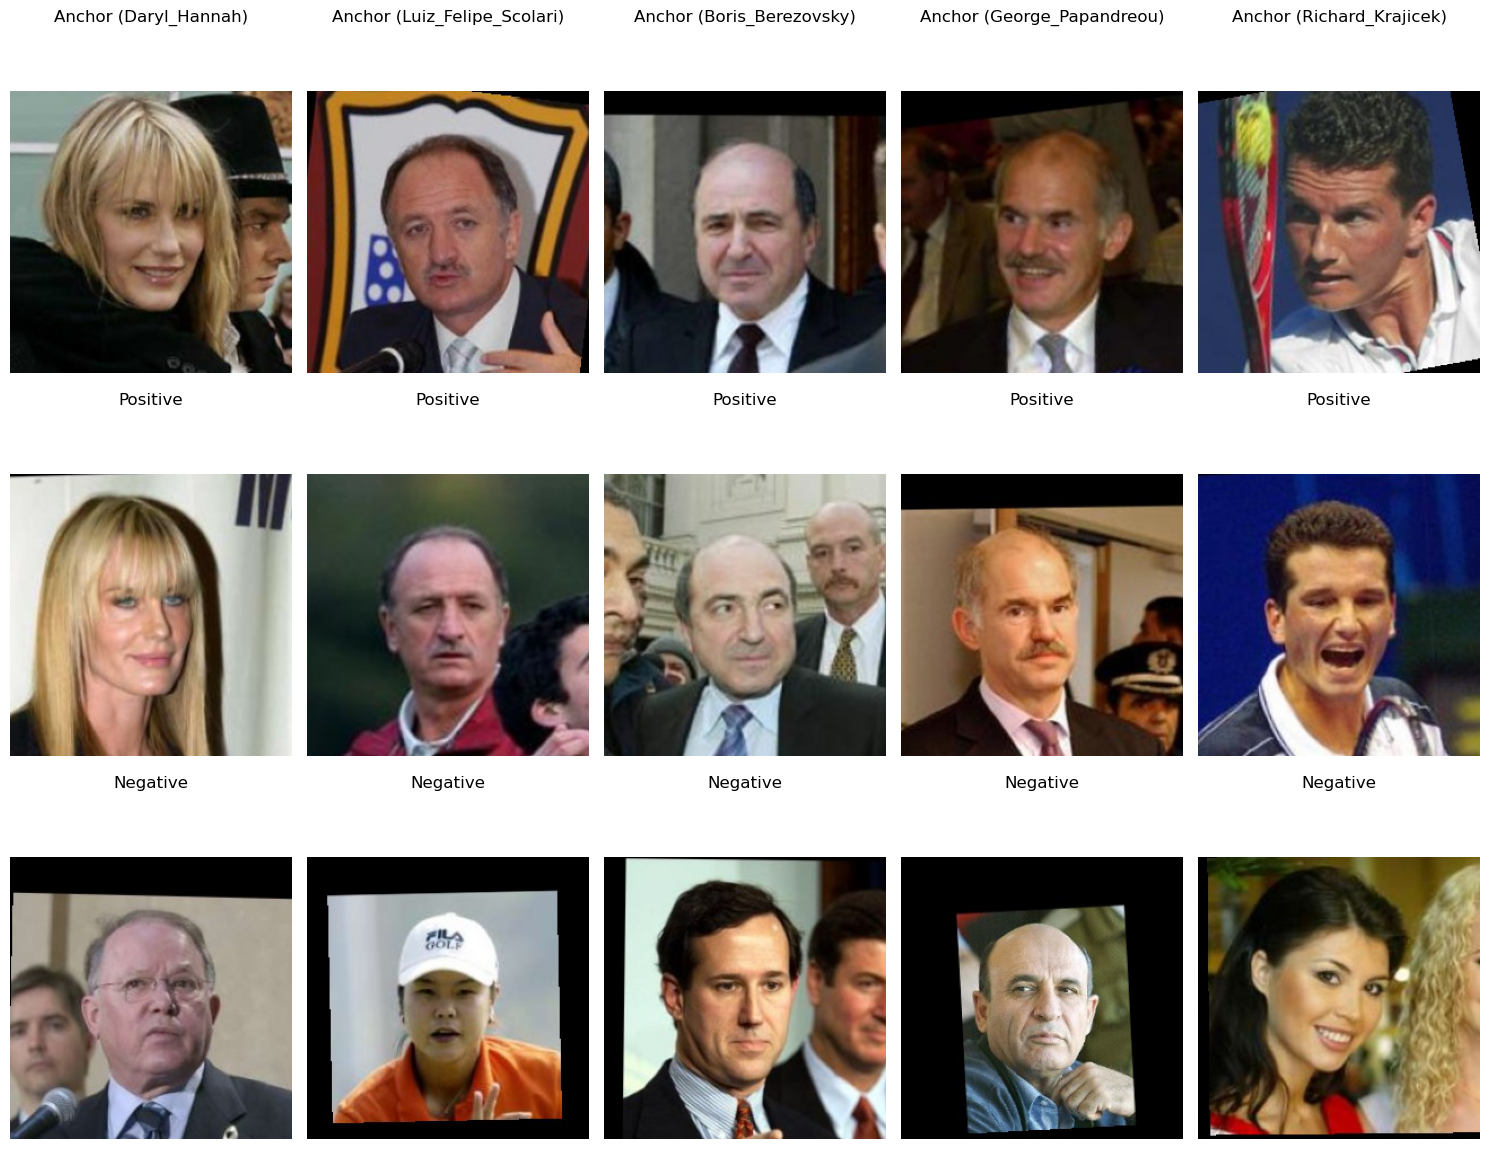

In [2]:
def show_images(dataset, num_samples=5):
    fig, axes = plt.subplots(3, num_samples, figsize=(num_samples*3, 12))
    
    # Handle single sample case
    if num_samples == 1:
        axes = axes.reshape(-1, 1)
    
    # Randomly sample indices
    sample_indices = random.sample(range(len(dataset)), min(num_samples, len(dataset)))
    
    for col, dataset_idx in enumerate(sample_indices):
        anchor, positive, negative = dataset[dataset_idx]

        anchor_name = dataset.get_person_name(dataset_idx)
        
        # Anchor (top row)
        axes[0, col].imshow(to_pil_image(anchor))
        axes[0, col].set_title(f'Anchor ({anchor_name})', pad=50)
        axes[0, col].axis('off')
        
        # Positive (middle row)
        axes[1, col].imshow(to_pil_image(positive))
        axes[1, col].set_title('Positive', pad=50)
        axes[1, col].axis('off')
        
        # Negative (bottom row)
        axes[2, col].imshow(to_pil_image(negative))
        axes[2, col].set_title('Negative', pad=50)
        axes[2, col].axis('off')
    
    plt.tight_layout()
    plt.show()

dataset = FaceDataset(data_dir=test_dir)
show_images(dataset)

In [3]:
from losses import TripletLoss
    
loss = TripletLoss()

In [4]:
random_sample = dataset[42]
len(random_sample)

3

In [5]:
test_loss = TripletLoss()
test_loss(random_sample[0], random_sample[1], random_sample[2])

tensor(1.9131)

In [6]:
def create_transforms():
    train_transforms = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomRotation(degrees=10),
        # transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
        # transforms.RandomGrayscale(p=0.1),
        transforms.ToTensor(),
    ])

    val_transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
    ])

    return train_transforms, val_transform

train_transforms, val_transform = create_transforms()

In [7]:
from face_embedding_cnn import FaceEmbeddingCNN

In [8]:
model = FaceEmbeddingCNN()

In [9]:
test_img = val_transform(to_pil_image(random_sample[0]))
model(test_img).shape

torch.Size([1, 512])

In [10]:
from face_embedding_trainer import FaceEmbeddingTrainer

In [11]:
device = torch.device('cuda' if torch.cuda.is_available() else "cpu")
print(f'Current device = {device}')

Current device = cuda


In [12]:
if torch.cuda.is_available():
    model.to('cuda')

In [13]:
lr = 0.001
weight_decay = 1e-4
optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)

train_data_dir = data_dir + '/train'
val_data_dir = data_dir + '/val'

train_dataset = FaceDataset(train_data_dir, transform=train_transforms)
val_dataset = FaceDataset(val_data_dir, transform=val_transform)

Loaded 1172 total people (with >= 2 photos)
Loaded 259 total people (with >= 2 photos)


In [14]:
train_subset_size = int(0.8 * len(train_dataset))
remaining_size = len(train_dataset) - train_subset_size
train_subset_dataset, _ = random_split(train_dataset, [train_subset_size, remaining_size])

val_subset_size = int(0.8 * len(val_dataset))
remaining_size = len(val_dataset) - val_subset_size
val_subset_dataset, _ = random_split(val_dataset, [val_subset_size, remaining_size])

print(f'Length of train subset dataset = {len(train_subset_dataset)}')
print(f'Length of val subset dataset = {len(val_subset_dataset)}')

Length of train subset dataset = 937
Length of val subset dataset = 207


In [15]:
batch_size = 32
num_workers = 4
# Full dataset
# train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
# val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)

# Subset dataset
train_loader = DataLoader(train_subset_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
val_loader = DataLoader(val_subset_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)

trainer = FaceEmbeddingTrainer(model, train_loader, val_loader, loss, device=device)

In [16]:
def train(trainer, epochs=1):
    best_val_loss = float('inf')

    for epoch in range(epochs):
        train_loss = trainer.train_epoch(optimizer, epoch)

        val_loss, accuracy = trainer.validate(epoch)

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            trainer.writer.add_text('Best_Model', f'Epoch {epoch}, Val Loss: {val_loss:.4f}, Accuracy: {accuracy:.4f}', epoch)

        print(f'Epoch {epoch}: Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')
    
    trainer.writer.close()

train(trainer, epochs=50)

Size of train loader dataset = 937
Started training epoch...
Loading batch 0
Loading batch 1
Loading batch 2
Loading batch 3
Loading batch 4
Loading batch 5
Loading batch 6
Loading batch 7
Loading batch 8
Loading batch 9
Loading batch 10
Loading batch 11
Loading batch 12
Loading batch 13
Loading batch 14
Loading batch 15
Loading batch 16
Loading batch 17
Loading batch 18
Loading batch 19
Loading batch 20
Loading batch 21
Loading batch 22
Loading batch 23
Loading batch 24
Loading batch 25
Loading batch 26
Loading batch 27
Loading batch 28
Loading batch 29
Finished training epoch...
Size of val loader dataset = 207
Starting validation step...
Loading batch 0
Loading batch 1
Loading batch 2
Loading batch 3
Loading batch 4
Loading batch 5
Loading batch 6
Finished validation step...
Epoch 0: Train Loss: 0.4995, Val Loss: 0.4674
Size of train loader dataset = 937
Started training epoch...
Loading batch 0
Loading batch 1
Loading batch 2
Loading batch 3
Loading batch 4
Loading batch 5
Loading 

In [18]:
!tensorboard --logdir=runs/face_embedding --port 6006

TensorFlow installation not found - running with reduced feature set.

NOTE: Using experimental fast data loading logic. To disable, pass
    "--load_fast=false" and report issues on GitHub. More details:
    https://github.com/tensorflow/tensorboard/issues/4784

I0729 01:06:59.704063 137389192230464 plugin.py:429] Monitor runs begin
Serving TensorBoard on localhost; to expose to the network, use a proxy or pass --bind_all
TensorBoard 2.13.0 at http://localhost:6006/ (Press CTRL+C to quit)
^C
